# Entrenamiento DQN - Tanque Simple

Notebook para entrenar agente DQN en control de nivel de tanque.

**Objetivo:** Controlar el nivel de un tanque ajustando el caudal de entrada.

---

## 1. Imports y Setup

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Agregar path del proyecto si es necesario
sys.path.append('../')

# Imports del proyecto
from Environment.Simulation_Env.tanque_simple import TankSimulator
from Environment.Simulation_Env.SimulationEnv import SimulationPIDEnv
from Environment.PIDControlEnv_simple import PIDControlEnv_Simple
from Agente.DQN.train_DQN import DQNTrainer
from Aux.Plots import SimplePlotter

print("Imports completados")
print(f"PyTorch version: {torch.__version__}")
print(f"Device disponible: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

Imports completados
PyTorch version: 2.2.2
Device disponible: CPU


## 2. Configuración del Experimento

In [2]:
# Configuración base
config = {
    # AMBIENTE
    'env_config': {
        'architecture': 'simple',
        'n_manipulable_vars': 1,
        'manipulable_ranges': [(0.0, 10.0)],  # Altura del tanque [m]
        'manipulable_setpoints': [5.0],  # Setpoint inicial
        'dt_usuario': 1.0,
        'max_steps': 200,
        
        'agent_controller_config': {
            'agent_type': 'discrete'  # Acciones discretas
        },
        
        # Configuración del simulador de tanque
        'env_type_config': {
            'area': 1.0,          # Área del tanque [m²]
            'cv': 0.1,            # Coeficiente de descarga
            'max_height': 10.0,   # Altura máxima [m]
            'max_flow_in': 0.5,   # Caudal máximo entrada [m³/s]
            'dt': 1.0
        }
    },
    
    # AGENTE CTRL
    'agent_ctrl_config': {
        'state_dim': 5,   # pv, sp, error, error_integral, error_derivative
        'action_dim': 7,  # 7 acciones discretas (Kp↑, Ki↑, Kd↑, Kp↓, Ki↓, Kd↓, mantener)
        'n_vars': 1,
        'hidden_dims': (128, 64),
        'lr': 0.001,
        'gamma': 0.99,
        'epsilon_start': 1.0,
        'epsilon_min': 0.01,
        'epsilon_decay': 0.995,
        'batch_size': 32,
        'target_update_freq': 100,
        'buffer_type': 'simple',  # 'simple' o 'priority'
        'buffer_size': 10000,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'seed': 42
    },
    
    # ENTRENAMIENTO
    'n_episodes': 300,
    'max_steps_per_episode': 200,
    'eval_frequency': 50,
    'save_frequency': 9999,  # No guardar periódicamente
    'log_frequency': 10,
    
    # LOGGING (comentado)
    'checkpoint_dir': 'checkpoints/tank_simple',
    # 'use_wandb': False,
}

print("Configuración creada")
print(f"\nEpisodios de entrenamiento: {config['n_episodes']}")
print(f"Device: {config['agent_ctrl_config']['device']}")
print(f"Buffer type: {config['agent_ctrl_config']['buffer_type']}")

Configuración creada

Episodios de entrenamiento: 300
Device: cpu
Buffer type: simple


## 3. Crear Ambiente de Prueba

Verificar que el ambiente funciona correctamente.

In [3]:
# Test del ambiente
test_env = PIDControlEnv_Simple(config['env_config'])
sim_cfg = config.get('env_config', {}).get('env_type_config', {}) or {}
simulator = TankSimulator(**sim_cfg)
test_env.proceso.connect_external_process(simulator)
print('TankSimulator conectado automáticamente al proceso')
print("Testing ambiente")
print(f"Observation space: {test_env.observation_space}")
print(f"Action space: {test_env.action_space}")

# Reset
obs, info = test_env.reset()
print(f"\nObservación inicial: {obs}")
print(f"Info inicial: {info}")

# Step aleatorio
random_action = test_env.action_space.sample()
obs, reward, terminated, truncated, info = test_env.step(random_action)

print(f"\nDespués de acción aleatoria {random_action}:")
print(f"  Observación: {obs}")
print(f"  Reward: {reward:.3f}")
print(f"  Terminated: {terminated}")
print(f"  Truncated: {truncated}")
print(f"  Info: {info}")

print("\nAmbiente funcionando correctamente")

TankSimulator conectado automáticamente al proceso
Testing ambiente
Observation space: Box(-inf, inf, (5,), float32)
Action space: MultiDiscrete([7])

Observación inicial: [7.396186 5.866788 0.       0.       0.      ]
Info inicial: {'trajectory_manipulable': [[]], 'energy': 0.0, 'overshoot_manipulable': [0.0], 'accumulated_error_manipulable': [0.0]}

Después de acción aleatoria [6]:
  Observación: [5.756153   5.866788   0.11063457 0.11063457 0.11063457]
  Reward: -47.801
  Terminated: True
  Truncated: False
  Info: {'trajectory_manipulable': [[7.396185833517471, 0.0, 0.5058145943464739, 0.9316854387178303, 1.336534692476996, 1.7193838744108465, 2.093677517696905, 2.440768110216505, 2.7851461121892895, 3.125537887782197, 3.4371460620609637, 3.7489431734961243, 4.061541673075599, 4.358717080073941, 4.643474353869942, 4.932751716583265, 5.218587706166237, 5.492091047329936, 5.756153198904502]], 'energy': 105.75317032363122, 'overshoot_manipulable': [26.068746988302948], 'accumulated_err

In [4]:
# Test de persistencia de parámetros PID
env = PIDControlEnv_Simple(config['env_config'])
simulator = TankSimulator(**sim_cfg)
env.proceso.connect_external_process(simulator)

# Episodio 1
env.reset()
print(f"Episodio 1 - Kp inicial: {env.pid_controllers[0].kp:.4f}")

# Simular ajuste manual
env.pid_controllers[0].kp = 1.5
print(f"Episodio 1 - Kp modificado: {env.pid_controllers[0].kp:.4f}")

# Episodio 2 (reset)
env.reset()
print(f"Episodio 2 - Kp después de reset: {env.pid_controllers[0].kp:.4f}")

# ✅ Debería imprimir:
# Episodio 1 - Kp inicial: 1.0000
# Episodio 1 - Kp modificado: 1.5000
# Episodio 2 - Kp después de reset: 1.5000  ← Se mantiene!

Episodio 1 - Kp inicial: 1.0000
Episodio 1 - Kp modificado: 1.5000
Episodio 2 - Kp después de reset: 1.5000


## 4. Crear Trainer y Comenzar Entrenamiento

In [5]:
# Crear trainer
trainer = DQNTrainer(config)

# Conectar simulador al ambiente del TRAINER
sim_cfg = config.get('env_config', {}).get('env_type_config', {}) or {}
simulator = TankSimulator(**sim_cfg)
trainer.env.proceso.connect_external_process(simulator)
print('TankSimulator conectado al trainer')

# Entrenar
print("\n Iniciando entrenamiento...\n")
trainer.train()
print("\n Entrenamiento completado")

TankSimulator conectado al trainer

 Iniciando entrenamiento...


Episodio 0/300
  Reward: -86.73
  Length: 1
  CTRL Loss: 0.0000
  CTRL Epsilon: 1.0000

Episodio 10/300
  Reward: -51.87
  Length: 1
  CTRL Loss: 0.0000
  CTRL Epsilon: 1.0000

Episodio 20/300
  Reward: -23.43
  Length: 1
  CTRL Loss: 0.0000
  CTRL Epsilon: 1.0000

Episodio 30/300
  Reward: -275.98
  Length: 1
  CTRL Loss: 0.0000
  CTRL Epsilon: 1.0000

Episodio 40/300
  Reward: -17.10
  Length: 1
  CTRL Loss: 1177344.5000
  CTRL Epsilon: 0.9511

Episodio 50/300
  Reward: -334.20
  Length: 1
  CTRL Loss: 421107.4062
  CTRL Epsilon: 0.9046
Evaluación: Reward promedio = -78.73
Agente guardado en: checkpoints/tank_simple/agent_ctrl_best.pt
Checkpoint guardado: best

Episodio 60/300
  Reward: -562.03
  Length: 1
  CTRL Loss: 136725.1875
  CTRL Epsilon: 0.8604

Episodio 70/300
  Reward: -67.15
  Length: 1
  CTRL Loss: 1077001.1250
  CTRL Epsilon: 0.8183

Episodio 80/300
  Reward: -579.62
  Length: 1
  CTRL Loss: 176252.1875
 

## 5. Análisis de Resultados


RESUMEN DE ENTRENAMIENTO

Métrica                        Último       Promedio     Mejor       
Reward                             -104.48     -371.10       -0.21
Energy                              155.98     1081.36        0.00
Max Overshoot (%)                    73.07      154.44        0.00

 Mejor episodio: #161 (Reward: -0.21)
Mejora total: -20.5%
Total episodios: 300


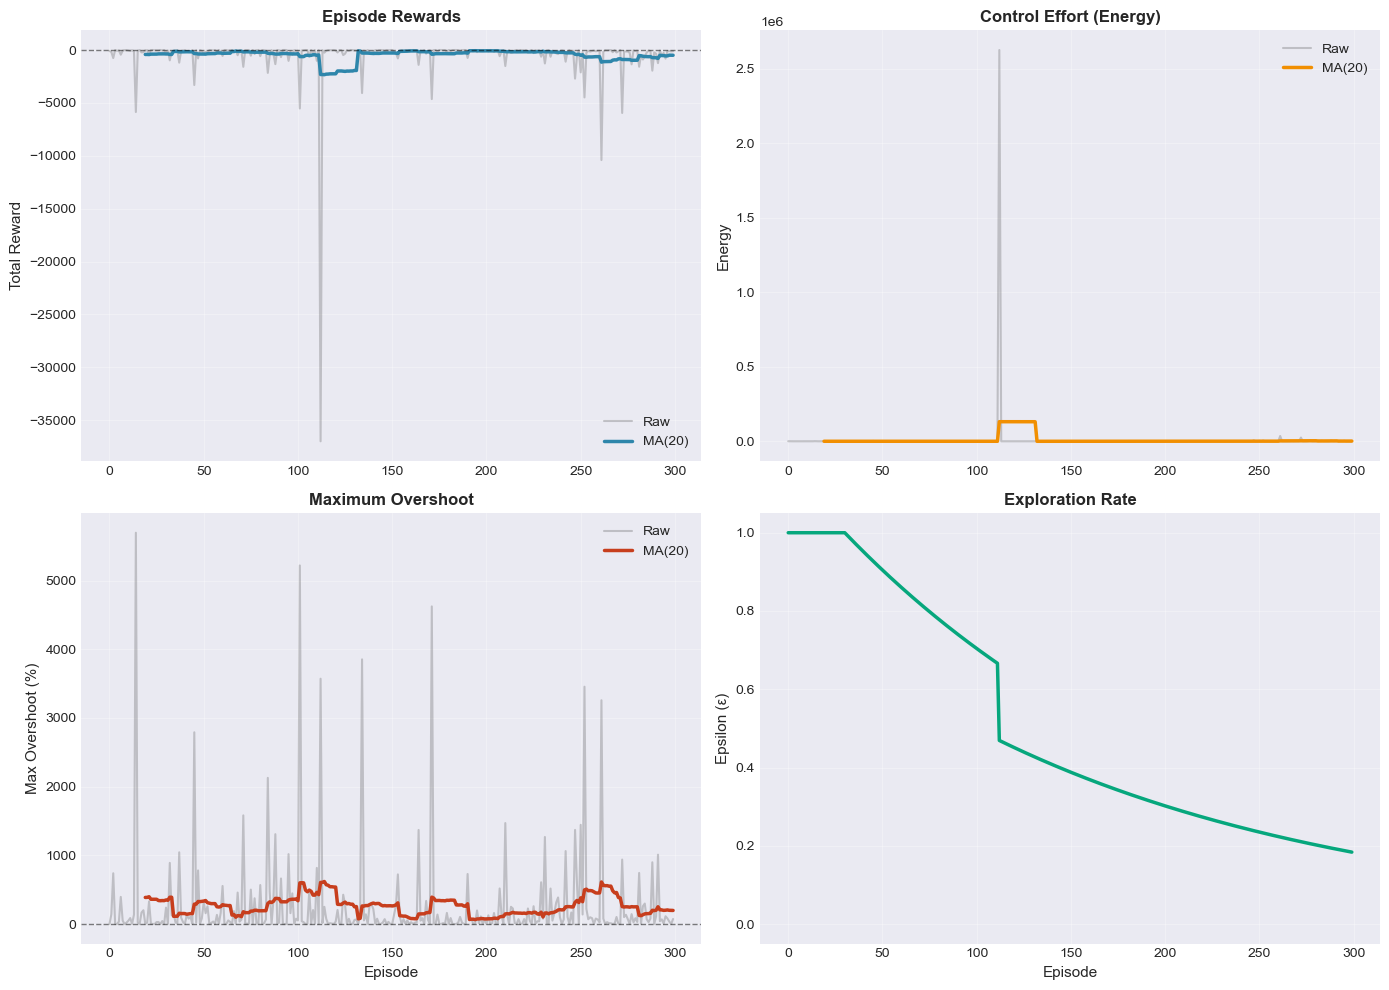

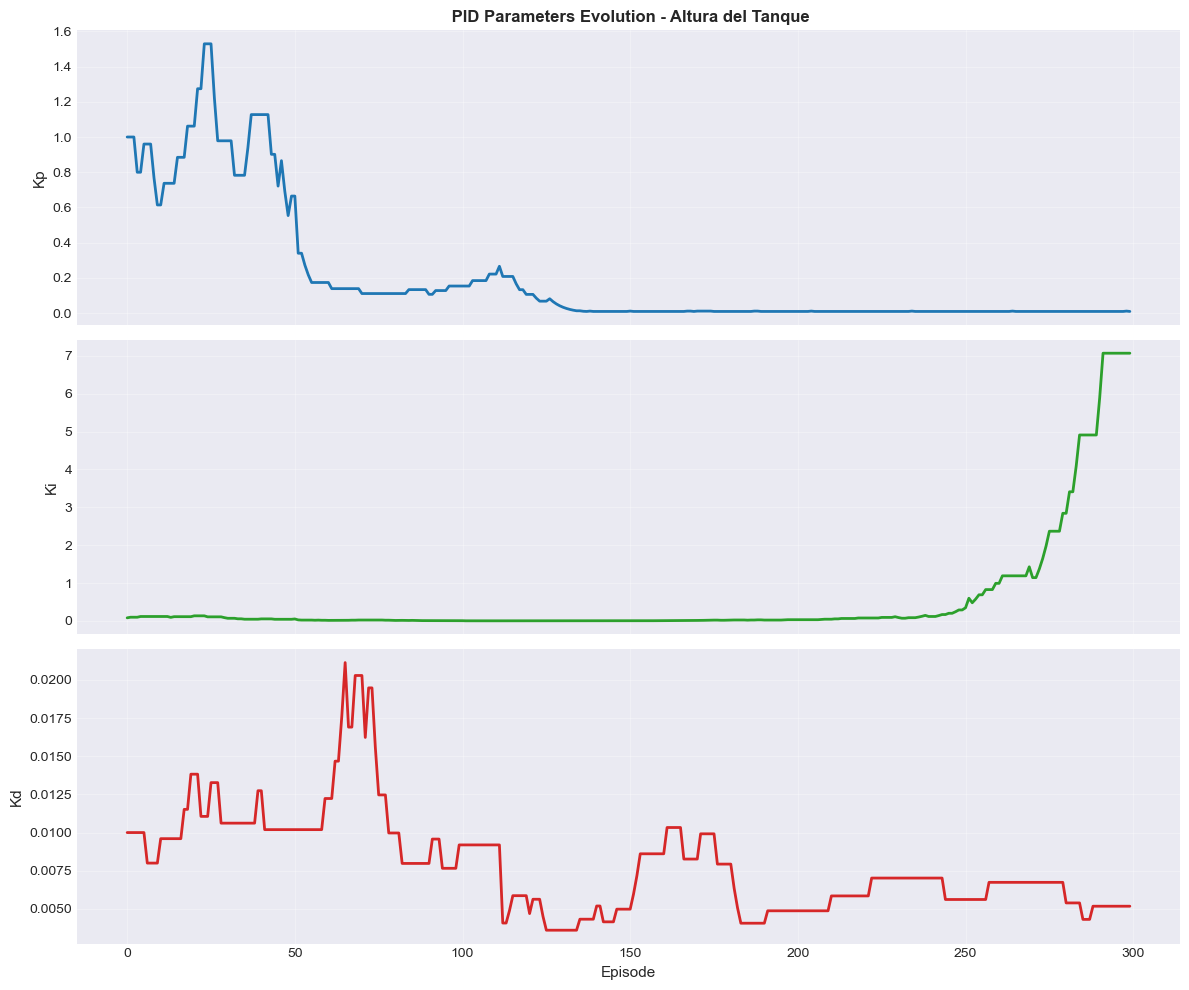

In [6]:
from Aux.Plots import SimplePlotter, print_summary
import numpy as np

plotter = SimplePlotter()

# Resumen textual
print("\n" + "="*70)
print_summary(
    episode_rewards=trainer.episode_rewards,
    episode_energies=trainer.episode_energies,
    episode_max_overshoots=trainer.episode_max_overshoots,
    best_episode_idx=np.argmax(trainer.episode_rewards)
)
print("="*70)

# Gráficos generales
plotter.plot_training_overview(
    episode_rewards=trainer.episode_rewards,
    episode_energies=trainer.episode_energies,
    episode_max_overshoots=trainer.episode_max_overshoots,
    epsilons=trainer.epsilons,
    window=20
)

# Evolución de parámetros PID
plotter.plot_pid_evolution(
    kp_history=trainer.kp_history,
    ki_history=trainer.ki_history,
    kd_history=trainer.kd_history,
    var_name="Altura del Tanque"
)

🏆 Mejor episodio: #161
  Reward: -0.21

🔧 Parámetros PID del mejor episodio:
  Kp = 0.0100
  Ki = 0.0067
  Kd = 0.0103

🚀 Simulando desde PV=2.0m hasta SP=7.0m...

✅ Simulación completada:
  Tiempo de convergencia: 33.0 s
  PV final: 6.881 m
  Convergió: Sí
  Pasos simulados: 34


/var/folders/p9/x4lzjw9n02j95nfzjt_b71600000gn/T/ipykernel_83386/1292259210.py:86: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


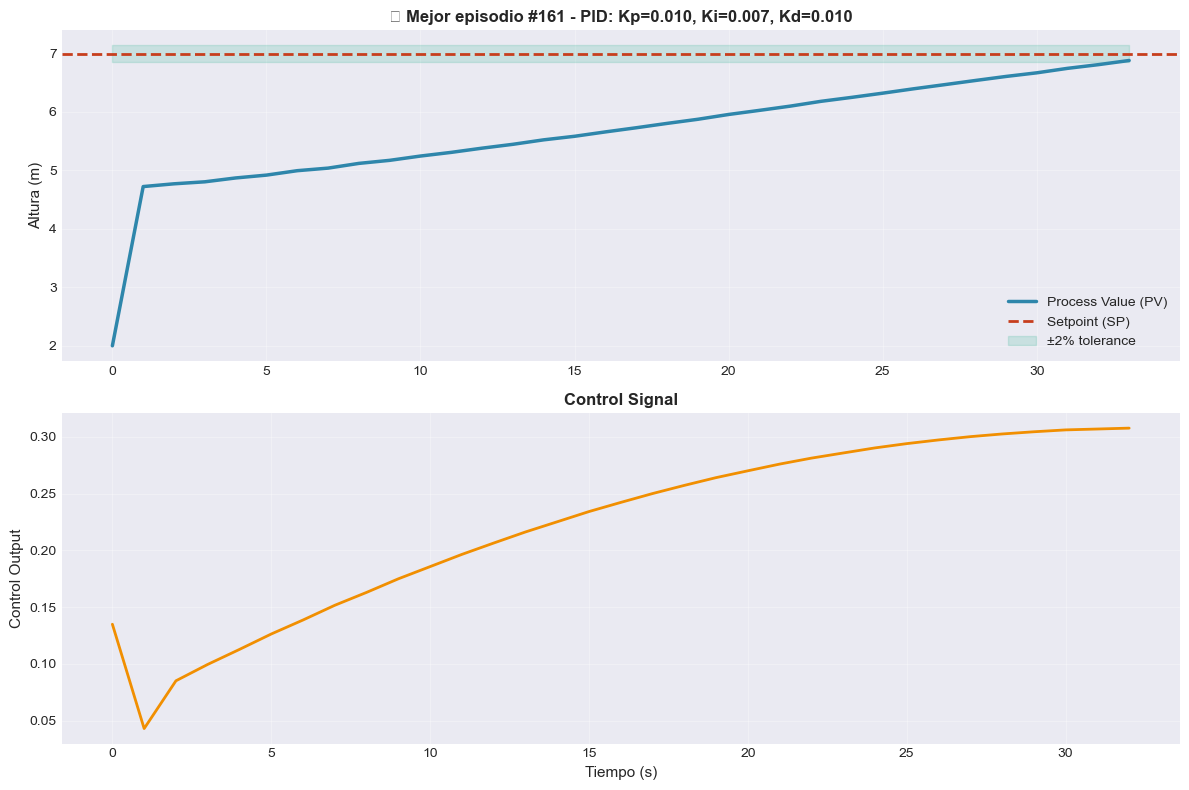

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 1. ENCONTRAR EPISODIO CON MEJOR REWARD
best_episode_idx = np.argmax(trainer.episode_rewards)
best_reward = trainer.episode_rewards[best_episode_idx]

# 2. OBTENER PARÁMETROS PID DE ESE EPISODIO
kp_best = trainer.kp_history[best_episode_idx]
ki_best = trainer.ki_history[best_episode_idx]
kd_best = trainer.kd_history[best_episode_idx]

print(f"🏆 Mejor episodio: #{best_episode_idx}")
print(f"  Reward: {best_reward:.2f}")
print(f"\n🔧 Parámetros PID del mejor episodio:")
print(f"  Kp = {kp_best:.4f}")
print(f"  Ki = {ki_best:.4f}")
print(f"  Kd = {kd_best:.4f}")

# 3. CREAR PID CON ESOS PARÁMETROS
from Aux.PIDComponents_PID import PIDController
from Aux.PIDComponents_time import ResponseTimeDetector

pid_best = PIDController(kp=kp_best, ki=ki_best, kd=kd_best, dt=1.0)

# 4. SIMULAR CONVERGENCIA
detector = ResponseTimeDetector(
    proceso=trainer.env.proceso,
    variable_index=0,
    env_type='simulation',
    dt=1.0,
    tolerance=0.02
)

# Condiciones de simulación
pv_inicial = 2.0   # Altura inicial
sp_objetivo = 7.0  # Setpoint objetivo

print(f"\n🚀 Simulando desde PV={pv_inicial:.1f}m hasta SP={sp_objetivo:.1f}m...")

resultado = detector.estimate(
    pv_inicial=pv_inicial,
    sp=sp_objetivo,
    pid_controller=pid_best,
    max_time=300
)

# 5. MOSTRAR RESULTADOS
print(f"\n✅ Simulación completada:")
print(f"  Tiempo de convergencia: {resultado['tiempo']:.1f} s")
print(f"  PV final: {resultado['pv_final']:.3f} m")
print(f"  Convergió: {'Sí' if resultado['converged'] else 'No'}")
print(f"  Pasos simulados: {len(resultado['trayectoria_pv'])}")

# 6. GRAFICAR
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

steps = np.arange(len(resultado['trayectoria_pv']))

# GRÁFICO 1: PV vs SP
ax = axes[0]
ax.plot(steps, resultado['trayectoria_pv'], label='Process Value (PV)', 
        color='#2E86AB', linewidth=2.5)
ax.axhline(y=sp_objetivo, label='Setpoint (SP)', 
           color='#C73E1D', linestyle='--', linewidth=2)

# Banda ±2%
ax.fill_between(steps, sp_objetivo * 0.98, sp_objetivo * 1.02,
                alpha=0.15, color='#06A77D', label='±2% tolerance')

ax.set_ylabel('Altura (m)', fontsize=11)
ax.set_title(f'🏆 Mejor episodio #{best_episode_idx} - PID: Kp={kp_best:.3f}, Ki={ki_best:.3f}, Kd={kd_best:.3f}', 
             fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# GRÁFICO 2: Señal de control
ax = axes[1]
ax.plot(steps[:-1], resultado['trayectoria_control'], 
        color='#F18F01', linewidth=2)
ax.set_xlabel('Tiempo (s)', fontsize=11)
ax.set_ylabel('Control Output', fontsize=11)
ax.set_title('Control Signal', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Peor episodio: #112
  Reward: -36986.58

🔧 Parámetros PID del mejor episodio:
  Kp = 0.2086
  Ki = 0.0014
  Kd = 0.0041

🚀 Simulando desde PV=2.0m hasta SP=7.0m...

✅ Simulación completada:
  Tiempo de convergencia: 8.0 s
  PV final: 7.137 m
  Convergió: Sí
  Pasos simulados: 9


/var/folders/p9/x4lzjw9n02j95nfzjt_b71600000gn/T/ipykernel_83386/2756059314.py:86: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  plt.tight_layout()


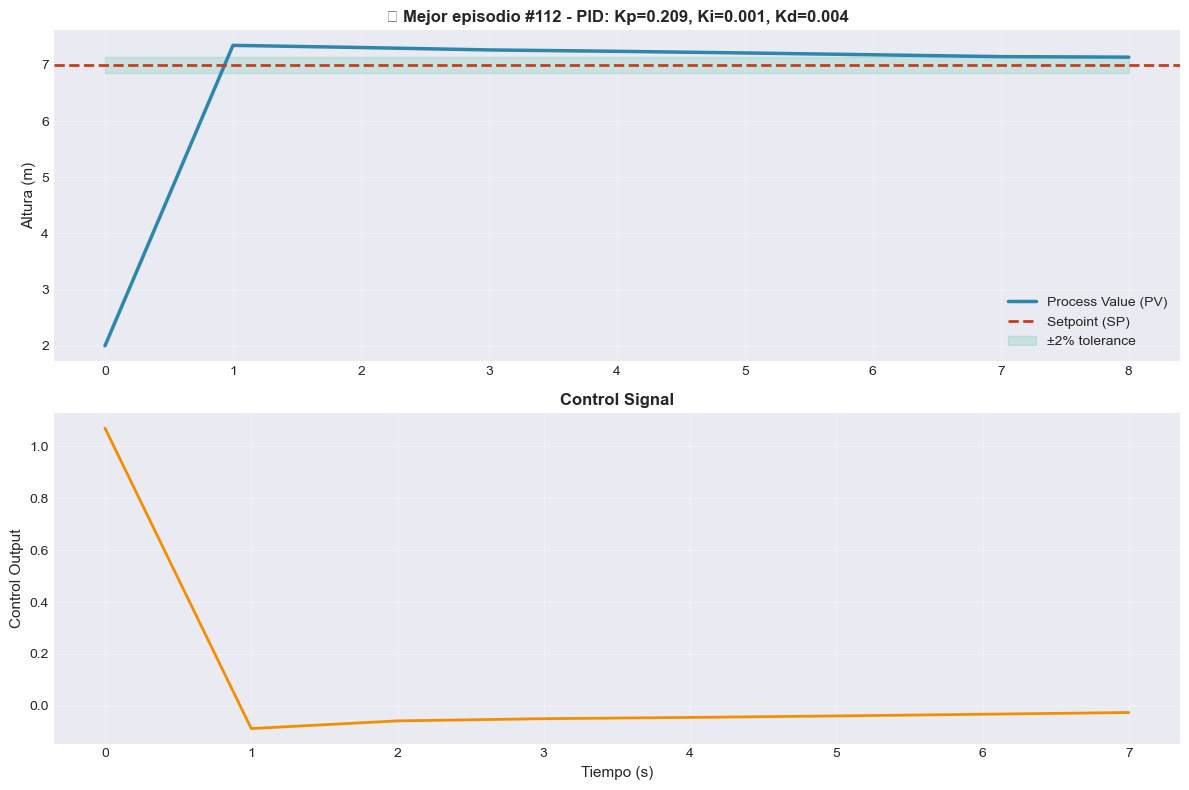

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 1. ENCONTRAR EPISODIO CON MEJOR REWARD
worst_episode_idx = np.argmin(trainer.episode_rewards)
worst_reward = trainer.episode_rewards[worst_episode_idx]

# 2. OBTENER PARÁMETROS PID DE ESE EPISODIO
kp_worst = trainer.kp_history[worst_episode_idx]
ki_worst = trainer.ki_history[worst_episode_idx]
kd_worst = trainer.kd_history[worst_episode_idx]

print(f"Peor episodio: #{worst_episode_idx}")
print(f"  Reward: {worst_reward:.2f}")
print(f"\n🔧 Parámetros PID del mejor episodio:")
print(f"  Kp = {kp_worst:.4f}")
print(f"  Ki = {ki_worst:.4f}")
print(f"  Kd = {kd_worst:.4f}")

# 3. CREAR PID CON ESOS PARÁMETROS
from Aux.PIDComponents_PID import PIDController
from Aux.PIDComponents_time import ResponseTimeDetector

pid_worst = PIDController(kp=kp_worst, ki=ki_worst, kd=kd_worst, dt=1.0)

# 4. SIMULAR CONVERGENCIA
detector = ResponseTimeDetector(
    proceso=trainer.env.proceso,
    variable_index=0,
    env_type='simulation',
    dt=1.0,
    tolerance=0.02
)

# Condiciones de simulación
pv_inicial = 2.0   # Altura inicial
sp_objetivo = 7.0  # Setpoint objetivo

print(f"\n🚀 Simulando desde PV={pv_inicial:.1f}m hasta SP={sp_objetivo:.1f}m...")

resultado = detector.estimate(
    pv_inicial=pv_inicial,
    sp=sp_objetivo,
    pid_controller=pid_worst,
    max_time=300
)

# 5. MOSTRAR RESULTADOS
print(f"\n✅ Simulación completada:")
print(f"  Tiempo de convergencia: {resultado['tiempo']:.1f} s")
print(f"  PV final: {resultado['pv_final']:.3f} m")
print(f"  Convergió: {'Sí' if resultado['converged'] else 'No'}")
print(f"  Pasos simulados: {len(resultado['trayectoria_pv'])}")

# 6. GRAFICAR
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

steps = np.arange(len(resultado['trayectoria_pv']))

# GRÁFICO 1: PV vs SP
ax = axes[0]
ax.plot(steps, resultado['trayectoria_pv'], label='Process Value (PV)', 
        color='#2E86AB', linewidth=2.5)
ax.axhline(y=sp_objetivo, label='Setpoint (SP)', 
           color='#C73E1D', linestyle='--', linewidth=2)

# Banda ±2%
ax.fill_between(steps, sp_objetivo * 0.98, sp_objetivo * 1.02,
                alpha=0.15, color='#06A77D', label='±2% tolerance')

ax.set_ylabel('Altura (m)', fontsize=11)
ax.set_title(f'🏆 Mejor episodio #{worst_episode_idx} - PID: Kp={kp_worst:.3f}, Ki={ki_worst:.3f}, Kd={kd_worst:.3f}', 
             fontsize=12, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

# GRÁFICO 2: Señal de control
ax = axes[1]
ax.plot(steps[:-1], resultado['trayectoria_control'], 
        color='#F18F01', linewidth=2)
ax.set_xlabel('Tiempo (s)', fontsize=11)
ax.set_ylabel('Control Output', fontsize=11)
ax.set_title('Control Signal', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()